# Feb 25th, 2022 (Entropy, carto)

**Motivation**: Entropy + cartography  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_cartography(
    df: pd.DataFrame,
    palette: Dict[str, str],
    xlim: Tuple[float, float] = None,
    ylim: Tuple[float, float] = None,
    hue: str = 'oc_idx',
    grid: bool = True,
    display: bool = True,
    leg_size: float = 14,
    size: float = 7,
    scatter_kws: dict = None,
    density_kws: dict = None,
    median_kws: dict = None, ):
    
    scatter_kws = scatter_kws if scatter_kws else {
        's': 120,
        'alpha': 0.9,
        'edgecolor': 'dimgrey',
    }
    density_kws = density_kws if density_kws else {
        'lw': 2,
        'fill': True,
        'alpha': 0.5,
    }
    median_kws = median_kws if median_kws else {
        'lw': 2,
        'ls': '--',
        'zorder': 0,
        'alpha': 1.0,
        'c': sns.color_palette('deep')[7],
    }
    
    set_style('ticks')
    jg = sns.JointGrid(
        data=df,
        x='entropy',
        y='degree',
        hue=hue,
        size=size,
        palette=palette,
        xlim=xlim,
        ylim=ylim,
        space=0.0,
    )
    # joint: scatter
    jg.plot_joint(
        sns.scatterplot,
        hue=hue,
        **scatter_kws,
    )
    # margnials: density
    jg.plot_marginals(
        sns.kdeplot,
        **density_kws,
    )
    # medians
    for name in ['entropy', 'degree']:
        x = df[name].median()
        lbl = f"median {name}: {x:.2f}"
        if name == 'entropy':
            jg.ax_joint.axvline(x, label=lbl, **median_kws)
        else:
            jg.ax_joint.axhline(x, label=lbl, **median_kws)
    # legend
    jg.ax_joint.legend(loc='upper left', prop={'size': leg_size})
    leg = leg = jg.ax_joint.get_legend()
    if leg is not None:
        plt.setp(leg, bbox_to_anchor=(1.3, 1.0))
    
    if grid:
        jg.ax_joint.grid()
    
    if display:
        plt.show()
    else:
        plt.close()
    return jg


def plot_swarm(
        df: pd.DataFrame,
        palette: dict,
        variable: str = 'entropy',
        display: bool = True,
        **kwargs, ):
    defaults = {
        'sensory_idxs': [2, 3],
        'kind': 'swarm',
        'aspect': 1.2,
        's': 12,
        'x_fontsize': 15,
        'title_fontsize': 15,
        'xtick_labelsize': 13,
        'ytick_labelsize': 14,
    }
    for k, v in defaults.items():
        if k not in kwargs:
            kwargs[k] = v

    median = df[variable].median()
    sns.set_theme(style='ticks')
    fg = sns.catplot(
        x=variable,
        y='tag',
        data=df,
        hue='oc_idx',
        col='oc_type',
        order=sorted(df['tag'].unique()),
        palette=palette,
        kind=kwargs['kind'],
        aspect=kwargs['aspect'],
        s=kwargs['s'],
    )
    for ax in fg.axes.ravel():
        ax.axvline(
            x=median,
            ls='--',
            lw=2,
            alpha=1.0,
            c=sns.color_palette('deep')[7],
            label=f"median {variable}: {median:.2f}",
            zorder=0,
        )
        ax.tick_params('x', labelsize=kwargs['xtick_labelsize'])
        ax.tick_params('y', labelsize=kwargs['ytick_labelsize'])
        ax.title.set_fontsize(kwargs['title_fontsize'])
        ax.set_xlabel(variable, fontsize=kwargs['x_fontsize'])
        ax.set_ylabel('')
        ax.grid(axis='y')

    if display:
        plt.show()
    else:
        plt.close()
    return fg

## Fig dir

In [3]:
fig_dir = pjoin(tmp_dir, 'fig_25th')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

In [6]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)

hr_bold = sp_stats.rankdata(h_bold)
hr_ca = sp_stats.rankdata(h_ca)

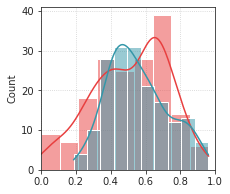

In [7]:
fig, ax = create_figure(figsize=(3.3, 2.8))
sns.histplot(h_bold, color=pal['bold-lite'], kde=True)
sns.histplot(h_ca, color=pal['ca2'], kde=True)
ax.set_xlim(0, 1)
ax.grid()

In [8]:
h_thres = -np.inf
hpb = gr_bold.project_vec(h_bold, thres=h_thres, add_disjoint=False)
hpc = gr_ca.project_vec(h_ca, thres=h_thres, add_disjoint=False)

hrpb = gr_bold.project_vec(hr_bold, thres=h_thres, add_disjoint=False)
hrpc = gr_ca.project_vec(hr_ca, thres=h_thres, add_disjoint=False)

In [12]:
trb = gr_bold.trim2d(hrpb)
trc = gr_bold.trim2d(hrpc)

In [36]:
from scipy.ndimage import gaussian_filter

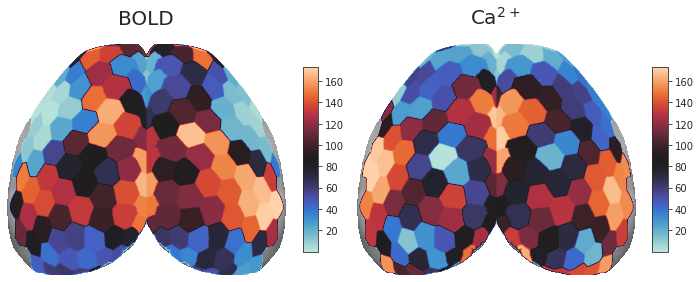

In [38]:
fig, axes = create_figure(1, 2, (10, 4))

x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
axes[0].imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
im = axes[0].imshow(x2p, cmap='icefire', interpolation='antialiased')
plt.colorbar(im, ax=axes[0], aspect=12, shrink=0.8)

x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
axes[1].imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
im = axes[1].imshow(x2p, cmap='icefire', interpolation='antialiased')
plt.colorbar(im, ax=axes[1], aspect=12, shrink=0.8)

axes[0].set_title('BOLD', fontsize=20, y=1.06)
axes[1].set_title(r'Ca$^{2+}$', fontsize=20, y=1.06)
remove_ticks(axes)

name = 'entropy'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

plt.show()

## Cartography

In [6]:
affil, affil_included = gr_bold.node_affiliations()

In [7]:
df_carto_ca = gr_ca.mk_cartography_df(affil=affil_included)
df_carto_bold = gr_bold.mk_cartography_df(affil=affil_included)
df_carto_bold = df_carto_bold.loc[~df_carto_bold['affil'].isin(['Auditory', 'Lateral'])]
df_carto_ca = df_carto_ca.loc[~df_carto_ca['affil'].isin(['Auditory', 'Lateral'])]

df_carto = pd.concat([df_carto_bold, df_carto_ca])

In [8]:
xlim = (-0.03, 0.7)
ylim = (2, 35)

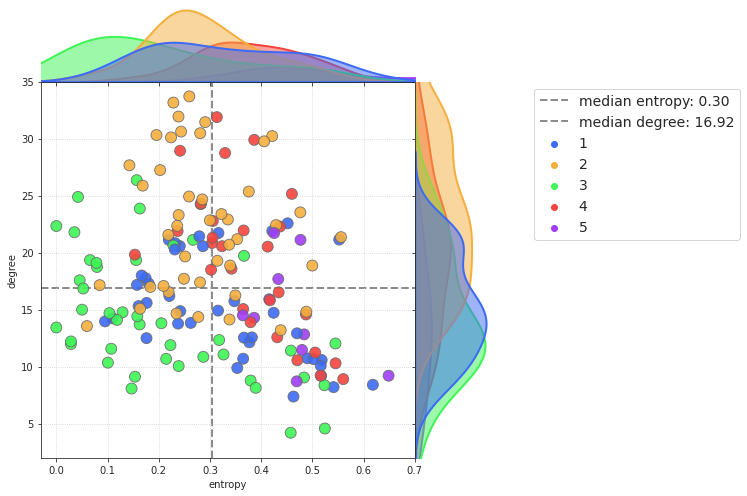

In [9]:
jg = plot_cartography(
    df=df_carto_bold,
    palette=gr_bold.colors,
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [12]:
name = 'cartography-bold_hue-oc'
figname = f"{name}.pdf"
jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

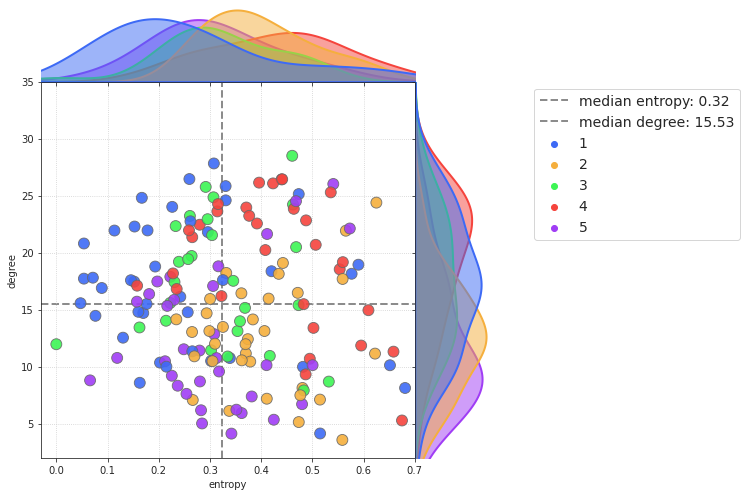

In [13]:
jg = plot_cartography(
    df=df_carto_ca,
    palette=gr_ca.colors,
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [14]:
name = 'cartography-ca_hue-oc'
figname = f"{name}.pdf"
jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

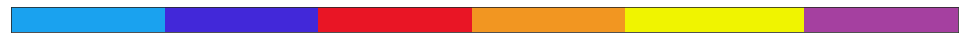

In [15]:
display_cmap(affil['cmap'])

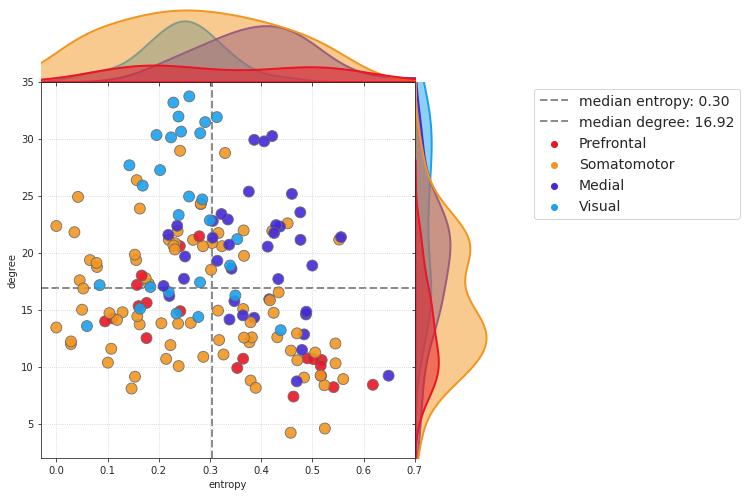

In [16]:
jg = plot_cartography(
    df=df_carto_bold,
    palette=affil['colors'],
    hue='affil',
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [17]:
name = 'cartography-bold_hue-affil'
figname = f"{name}.pdf"
jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

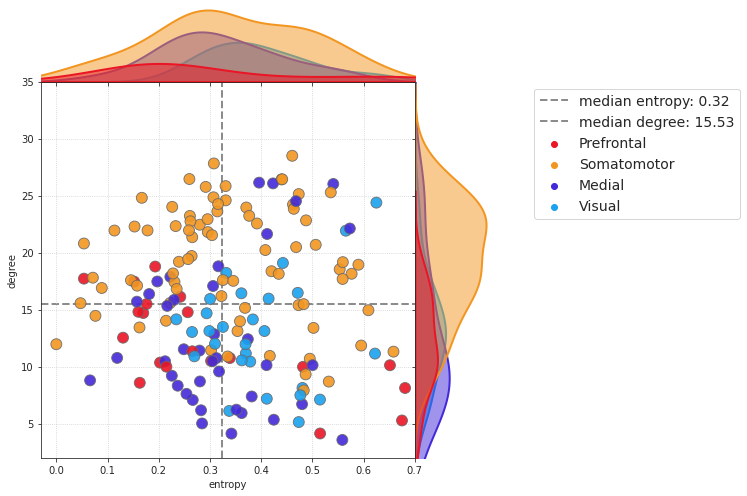

In [18]:

jg = plot_cartography(
    df=df_carto_ca,
    palette=affil['colors'],
    hue='affil',
    xlim=xlim,
    ylim=ylim,
    grid=True,
)

In [19]:
name = 'cartography-ca_hue-affil'
figname = f"{name}.pdf"
jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    jg.fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

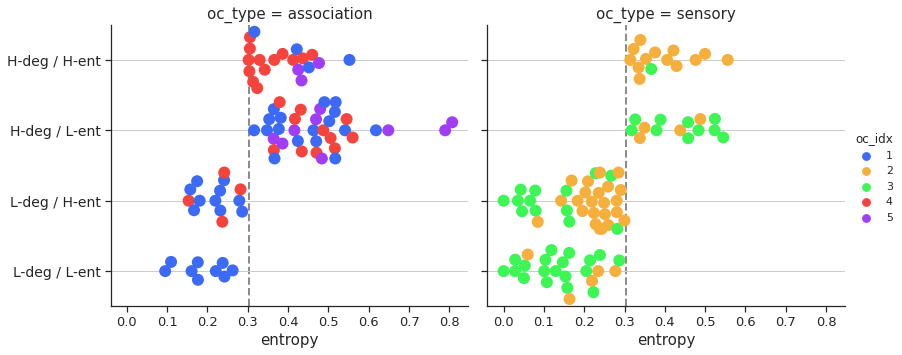

In [12]:
_ = plot_swarm(
    df=df_carto_bold,
    palette=gr_ca.colors,
)

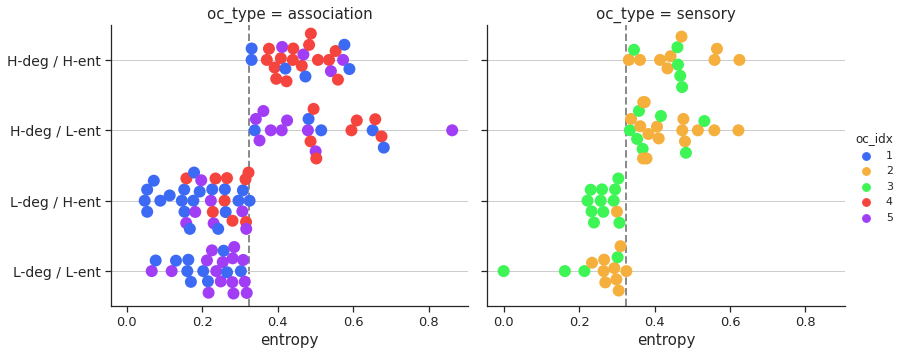

In [13]:
_ = plot_swarm(
    df=df_carto_ca,
    palette=gr_ca.colors,
)

### What about different h?

In [25]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)

### Weighted degrees

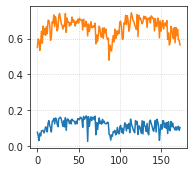

In [115]:
d_bold = res['a_bold'].mean(0)
d_ca = res['a_ca'].mean(0)

fig, ax = create_figure(figsize=(2.8, 2.5))
ax.plot(d_bold)
ax.plot(d_ca)
ax.grid()
plt.show()

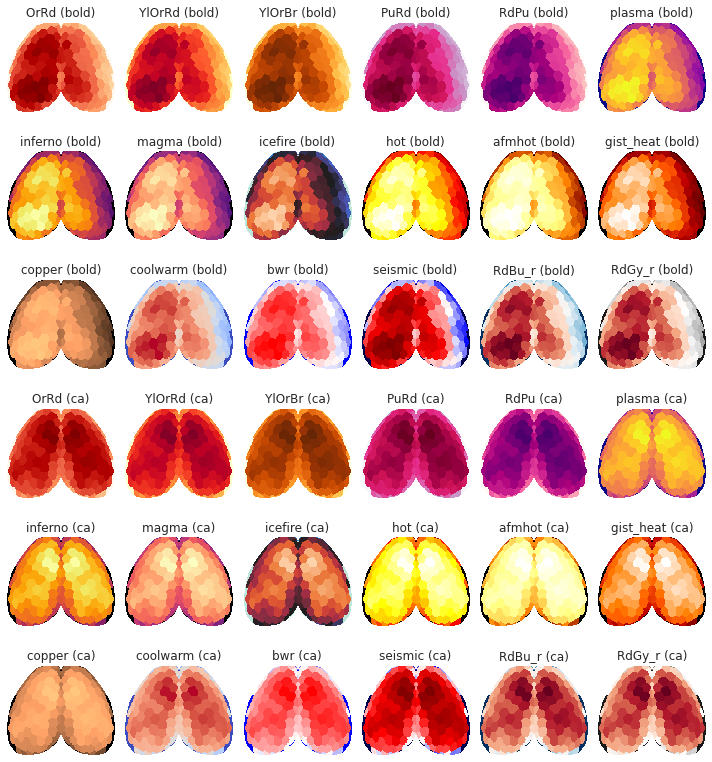

In [117]:
thres = -np.inf
dpb = gr_bold.project_vec(d_bold, thres=thres, add_disjoint=False)
dpc = gr_ca.project_vec(d_ca, thres=thres, add_disjoint=False)

trb = gr_bold.trim2d(dpb)
trc = gr_bold.trim2d(dpc)

fig, axes = create_figure(6, 6, (10, 11))

for cm, ax in zip(cm_candidates, axes[:3].flat):
    x2plt = np.ma.masked_where(trb['top'] == 0, trb['top'])
    ax.imshow(x2plt, cmap='Greys_r')
    x2plt = np.ma.masked_where(trb['top'] == 0, trb['proj-top'][0])
    ax.imshow(x2plt, cmap=cm, vmin=np.nanmin(d_bold), vmax=np.nanmax(d_bold))
    ax.set_title(f"{cm} (bold)")

for cm, ax in zip(cm_candidates, axes[3:].flat):
    x2plt = np.ma.masked_where(trc['top'] == 0, trc['top'])
    ax.imshow(x2plt, cmap='Greys_r')
    x2plt = np.ma.masked_where(trc['top'] == 0, trc['proj-top'][0])
    ax.imshow(x2plt, cmap=cm, vmin=np.nanmin(d_ca), vmax=np.nanmax(d_ca))
    ax.set_title(f"{cm} (ca)")
    
remove_ticks(axes)
plt.show()

## Voted out distribution

In [14]:
gr_ca.votes['votes'].shape

(174, 10, 5)

In [86]:
j, k = 3, 4
pi = gr_ca.run_pi
votes = gr_ca.votes['votes']
odd_ca = collections.defaultdict(list)
all_x_ca = []
for node in range(len(votes)):
    for anim in range(votes.shape[1]):
        v = votes[node, anim]
        v = v.reshape(1, 1, -1).astype(bool)
        v = np.repeat(v, j, axis=0)
        v = np.repeat(v, k, axis=1)
        x = pi[anim, ..., node][v]
        if len(x) and np.nanmax(x) > 0.9:
            odd_ca[mice.get_key(anim + 1)].append(node + 1)
        all_x_ca.extend(list(x))
odd_ca = dict(sorted(odd_ca.items()))
all_x_ca = np.array(all_x_ca)
all_x_ca = all_x_ca[np.isfinite(all_x_ca)]


pi = gr_bold.run_pi
votes = gr_bold.votes['votes']
odd_bold = collections.defaultdict(list)
all_x_bold = []
for node in range(len(votes)):
    for anim in range(votes.shape[1]):
        v = votes[node, anim]
        v = v.reshape(1, 1, -1).astype(bool)
        v = np.repeat(v, j, axis=0)
        v = np.repeat(v, k, axis=1)
        x = pi[anim, ..., node][v]
        if len(x) and np.nanmax(x) > 0.9:
            odd_bold[mice.get_key(anim + 1)].append(node + 1)
        all_x_bold.extend(list(x))
odd_bold = dict(sorted(odd_bold.items()))
all_x_bold = np.array(all_x_bold)
all_x_bold = all_x_bold[np.isfinite(all_x_bold)]

len(all_x_bold), len(all_x_ca)

(58536, 46982)

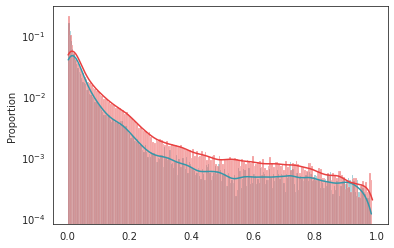

In [87]:
sns.histplot(all_x_ca, color=pal['ca2'], stat='proportion', kde=True)
sns.histplot(all_x_bold, color=pal['bold-lite'], stat='proportion', kde=True)
plt.yscale('log')

In [88]:
odd_ca

{
    'sub-SLC01': [
        5,
        9,
        10,
        12,
        65,
        84,
        85,
        87,
        94,
        96,
        97,
        99,
        100,
        102,
        103,
        105,
        106,
        109,
        111,
        113,
        172
    ],
    'sub-SLC03': [
        4,
        5,
        26,
        32,
        36,
        42,
        47,
        48,
        54,
        55,
        58,
        61,
        63,
        64,
        65,
        70,
        73,
        83,
        96,
        98,
        119,
        126,
        129,
        134,
        143,
        146,
        149,
        151,
        154,
        157,
        160,
        163,
        165,
        167,
        168,
        170,
        172
    ],
    'sub-SLC04': [
        2,
        4,
        16,
        17,
        32,
        40,
        42,
        46,
        48,
        49,
        53,
        54,
        55,
        58,
        61,
        63,
        67,
        68,
        69,
        74,
        78,
        79,
        81,
        88,
        89,
        90,
        91,
        92,
        93,
        94,
        96,
        97,
        100,
        111,
        119,
        154,
        161,
        163,
        164,
        166
    ],
    'sub-SLC05': [31, 39, 40, 42, 46, 48, 53, 54, 67, 77, 119, 120, 144, 153],
    'sub-SLC06': [9, 18, 22, 26, 100, 105, 109, 113],
    'sub-SLC07': [
        12,
        15,
        16,
        19,
        24,
        44,
        45,
        52,
        96,
        97,
        106,
        109,
        111,
        113,
        131,
        137
    ],
    'sub-SLC08': [3, 9, 13, 18, 22, 31, 73, 78, 85, 105],
    'sub-SLC09': [
        22,
        24,
        56,
        59,
        64,
        66,
        73,
        74,
        76,
        78,
        79,
        85,
        117,
        133,
        142,
        143,
        146,
        149,
        151,
        154,
        157,
        159,
        160,
        165,
        173
    ],
    'sub-SLC10': [
        3,
        5,
        10,
        64,
        73,
        74,
        78,
        97,
        99,
        100,
        103,
        106,
        109,
        113,
        116,
        160,
        163,
        165
    ]
}

In [89]:
xxx_ca = gr_ca.votes['votes'].sum(-1) == 5
xxx_bold = gr_bold.votes['votes'].sum(-1) == 5

xxx_ca.shape, xxx_bold.shape

((174, 10), (174, 10))

In [90]:
xxx_ca[4], xxx_bold[4]

(
    array([False, False,  True, False, False, False, False, False, False,
       False]),
    array([False, False, False, False, False, False, False,  True, False,
       False])
)

In [91]:
xxx_ca.sum(1)

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 4, 0, 0, 1,
       0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 3, 0, 1, 2, 1, 0, 2, 0, 3, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [92]:
xxx_bold.sum(1)

array([0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 3, 2, 0, 0, 0, 0,
       0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
xxx_ca.sum(), xxx_bold.sum()

(61, 54)

In [96]:
np.argmax(xxx_ca.sum(1)) + 1

85

In [98]:
xxx_ca[84]

array([ True, False, False,  True, False, False, False,  True,  True,
       False])

## Entropy

In [99]:
gr_ca_pruned_h = Group(**props_ca).load_group(use_pruned_for_h=True)
gr_bold_pruned_h = Group(**props_bold).load_group(use_pruned_for_h=True)

gr_ca_full_h = Group(**props_ca).load_group(use_pruned_for_h=False)
gr_bold_full_h = Group(**props_bold).load_group(use_pruned_for_h=False)

grp_h_new_ca = sp_stats.entropy(gr_ca.grp_pi_prune, axis=-2) / np.log(gr_ca.num_k)
grp_h_new_bold = sp_stats.entropy(gr_bold.grp_pi_prune, axis=-2) / np.log(gr_bold.num_k)

run_h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca_pruned_h.run_h, 2), 1), 0)
run_h_avg_bold = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold_pruned_h.run_h, 2), 1), 0)

pruned:

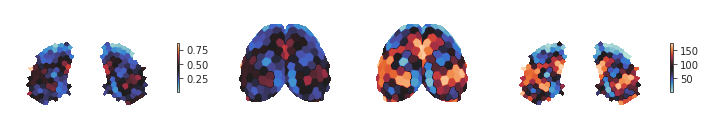

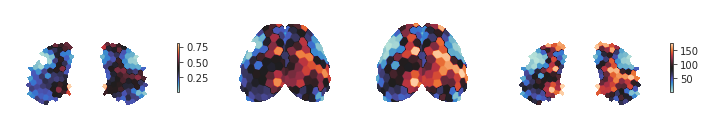

pruned, but new:

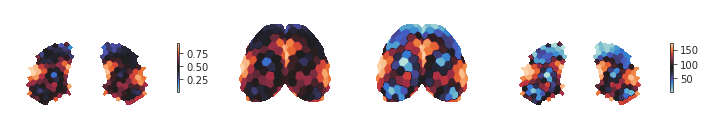

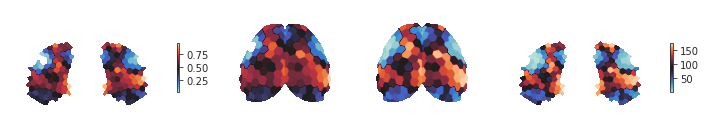

pruned, but run avg:

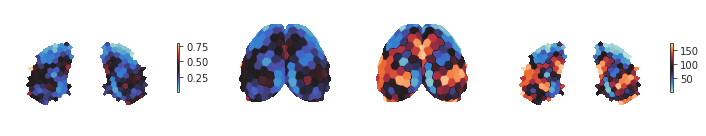

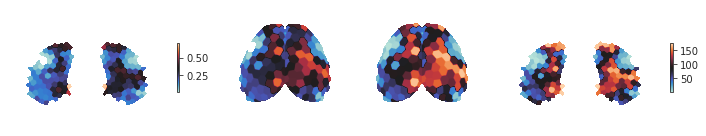

full:

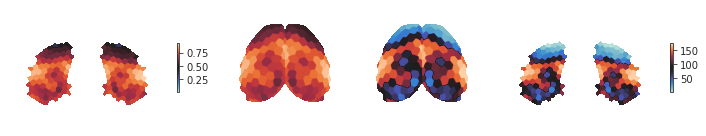

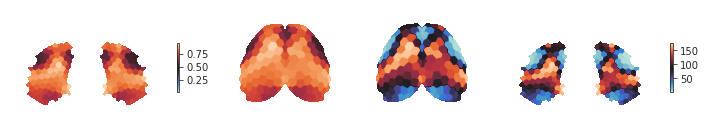

In [100]:
print('pruned:')
show_h(
    gr_ca_pruned_h.project_vec(gr_ca_pruned_h.grp_h, add_disjoint=False),
    gr_ca_pruned_h.project_vec(gr_ca_pruned_h.grp_hr, add_disjoint=False),
)
show_h(
    gr_bold_pruned_h.project_vec(gr_bold_pruned_h.grp_h, add_disjoint=False),
    gr_bold_pruned_h.project_vec(gr_bold_pruned_h.grp_hr, add_disjoint=False),
)

print('\npruned, but new:')
show_h(
    gr_ca.project_vec(grp_h_new_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(grp_h_new_ca), add_disjoint=False),
)
show_h(
    gr_bold.project_vec(grp_h_new_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(grp_h_new_bold), add_disjoint=False),
)

print('\npruned, but run avg:')
show_h(
    gr_ca.project_vec(run_h_avg_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(run_h_avg_ca), add_disjoint=False),
)
show_h(
    gr_bold.project_vec(run_h_avg_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(run_h_avg_bold), add_disjoint=False),
)

print('\n full:')
show_h(
    gr_ca_full_h.project_vec(gr_ca_full_h.grp_h, add_disjoint=False),
    gr_ca_full_h.project_vec(gr_ca_full_h.grp_hr, add_disjoint=False),
)
show_h(
    gr_bold_full_h.project_vec(gr_bold_full_h.grp_h, add_disjoint=False),
    gr_bold_full_h.project_vec(gr_bold_full_h.grp_hr, add_disjoint=False),
)

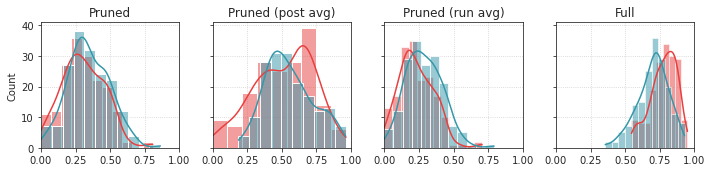

In [101]:
fig, axes = create_figure(1, 4, (10, 2.5), 'all', 'all')

sns.histplot(gr_bold_pruned_h.grp_h, kde=True, color=pal['bold-lite'], ax=axes[0])
sns.histplot(gr_ca_pruned_h.grp_h, kde=True, color=pal['ca2'], ax=axes[0])

sns.histplot(grp_h_new_bold, kde=True, color=pal['bold-lite'], ax=axes[1])
sns.histplot(grp_h_new_ca, kde=True, color=pal['ca2'], ax=axes[1])

sns.histplot(run_h_avg_bold, kde=True, color=pal['bold-lite'], ax=axes[2])
sns.histplot(run_h_avg_ca, kde=True, color=pal['ca2'], ax=axes[2])

sns.histplot(gr_bold_full_h.grp_h, kde=True, color=pal['bold-lite'], ax=axes[3])
sns.histplot(gr_ca_full_h.grp_h, kde=True, color=pal['ca2'], ax=axes[3])

axes[0].set_title('Pruned')
axes[1].set_title('Pruned (post avg)')
axes[2].set_title('Pruned (run avg)')
axes[3].set_title('Full')
axes[0].set_xlim(0, 1)
add_grid(axes)
plt.show()

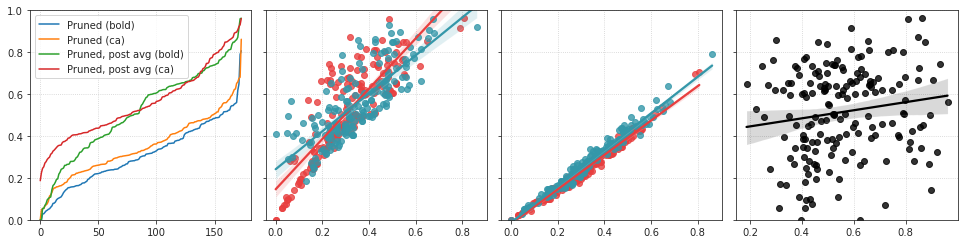

In [62]:
fig, axes = create_figure(1, 4, figsize=(13.5, 3.5), sharey='all')
axes[0].plot(sorted(gr_bold.grp_h), label='Pruned (bold)')
axes[0].plot(sorted(gr_ca.grp_h), label='Pruned (ca)')
axes[0].plot(sorted(grp_h_new_bold), label='Pruned, post avg (bold)')
axes[0].plot(sorted(grp_h_new_ca), label='Pruned, post avg (ca)')
axes[0].legend()
axes[0].set_ylim(0, 1)

sns.regplot(x=gr_bold.grp_h, y=grp_h_new_bold, color=pal['bold-lite'], ax=axes[1])
sns.regplot(x=gr_ca.grp_h, y=grp_h_new_ca, color=pal['ca2'], ax=axes[1])

sns.regplot(x=gr_bold.grp_h, y=run_h_avg_bold, color=pal['bold-lite'], ax=axes[2])
sns.regplot(x=gr_ca.grp_h, y=run_h_avg_ca, color=pal['ca2'], ax=axes[2])

sns.regplot(x=grp_h_new_ca, y=grp_h_new_bold, color='k', ax=axes[3])
# sns.regplot(x=grp_h_new_bold, y=grp_h_new_ca, color=pal['ca2'], ax=axes[3])
# sns.regplot(x=gr_ca.grp_h, y=gr_bold.grp_h, color='k', ax=axes[3])

add_grid(axes)

plt.show()

[<matplotlib.lines.Line2D object at 0x7f29caa58bb0>]

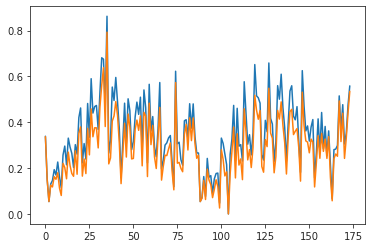

In [64]:
plt.plot(gr_ca.grp_h)
plt.plot(run_h_avg_ca)

## TODO: make a pairplot (add the bold, ca stuff there and tag pruned vs post avg vs full)

[<matplotlib.lines.Line2D object at 0x7f17a709fac0>]

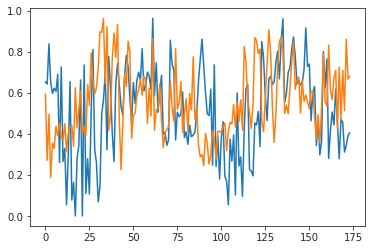

In [104]:
plt.plot(grp_h_new_bold)
plt.plot(grp_h_new_ca)

## Stacked bar plot

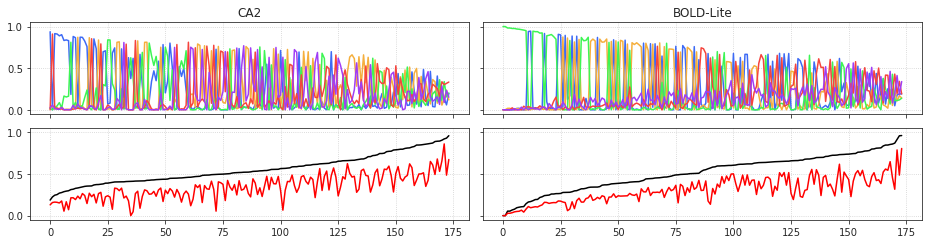

In [106]:
fig, axes = create_figure(2, 2, (13, 3.5), 'all', 'all')

sort = np.argsort(grp_h_new_ca)
for i in range(gr_ca.num_k):
    axes[0, 0].plot(gr_ca.grp_pi_prune[i][sort], color=gr_ca.colors[i + 1])
axes[1, 0].plot(grp_h_new_ca[sort], color='k')
axes[1, 0].plot(gr_ca.grp_h[sort], color='r')
axes[0, 0].set_title('CA2')

sort = np.argsort(grp_h_new_bold)
for i in range(gr_bold.num_k):
    axes[0, 1].plot(gr_bold.grp_pi_prune[i][sort], color=gr_bold.colors[i + 1])
axes[1, 1].plot(grp_h_new_bold[sort], color='k')
axes[1, 1].plot(gr_bold.grp_h[sort], color='r')
axes[0, 1].set_title('BOLD-Lite')

add_grid(axes)
plt.show()

In [115]:
grp_h_new_ca = sp_stats.entropy(gr_ca.grp_pi_prune, axis=-2) / np.log(gr_ca.num_k)
grp_h_new_bold = sp_stats.entropy(gr_bold.grp_pi_prune, axis=-2) / np.log(gr_bold.num_k)
grp_h_both = (grp_h_new_ca + grp_h_new_bold) / 2

sort_ca = np.argsort(grp_h_new_ca)
sort_bold = np.argsort(grp_h_new_bold)
sort_both = np.argsort(grp_h_both)

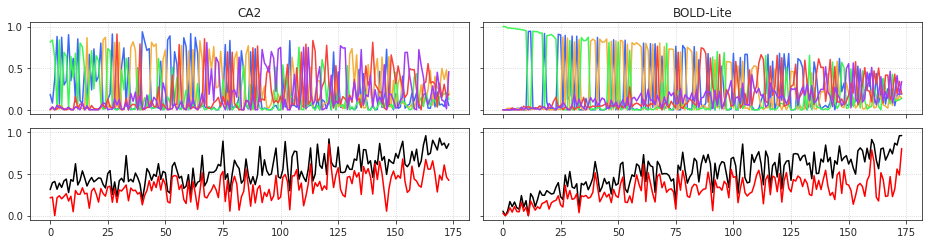

In [116]:
fig, axes = create_figure(2, 2, (13, 3.5), 'all', 'all')

for i in range(gr_ca.num_k):
    axes[0, 0].plot(gr_ca.grp_pi_prune[i][sort_both], color=gr_ca.colors[i + 1])
axes[1, 0].plot(grp_h_new_ca[sort_both], color='k')
axes[1, 0].plot(gr_ca.grp_h[sort_both], color='r')
axes[0, 0].set_title('CA2')

sort = np.argsort(grp_h_new_bold)
for i in range(gr_bold.num_k):
    axes[0, 1].plot(gr_bold.grp_pi_prune[i][sort], color=gr_bold.colors[i + 1])
axes[1, 1].plot(grp_h_new_bold[sort_both], color='k')
axes[1, 1].plot(gr_bold.grp_h[sort_both], color='r')
axes[0, 1].set_title('BOLD-Lite')

add_grid(axes)
plt.show()

In [117]:
sort_both[0]

12

In [119]:
gr_ca.grp_pi_prune[:, sort_both[0]], gr_bold.grp_pi_prune[:, sort_both[0]]

(
    memmap([0.18449166, 0.        , 0.81137915, 0.        , 0.0041292 ]),
    memmap([0.        , 0.01719355, 0.98280645, 0.        , 0.        ])
)

In [126]:
gr_ca.grp_pi_prune[0, labels]

array([0.18449166, 0.07980469, 0.375     , 0.88084286, 0.06917142,
       0.87215254, 0.29785313, 0.34537845, 0.90222057, 0.34904448])

In [125]:
gr_ca.grp_pi_prune[:, labels].shape

(5, 10)

In [138]:
sort_both.shape

(174,)

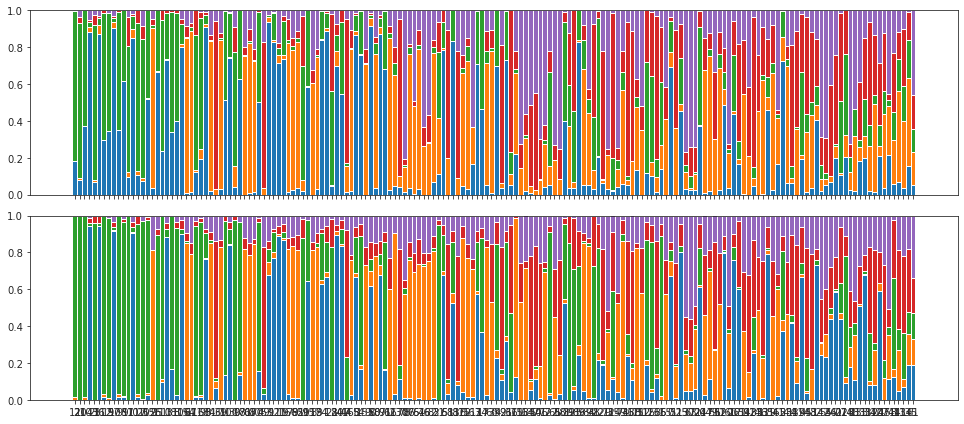

In [139]:
# nodes = np.array([sort_both[i] for i in range(100)])
nodes = sort_both
# men_means = [20, 35, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]
# men_std = [2, 3, 4, 1, 2]
# women_std = [3, 5, 2, 3, 3]
width = 1      # the width of the bars: can also be len(x) sequence

fig, axes = create_figure(2, 1, (13.5, 6), 'all', 'all')

bottom_ca = np.zeros(len(nodes))
bottom_bold = np.zeros(len(nodes))
for k in range(5):
    height = gr_ca.grp_pi_prune[k, nodes]
    axes[0].bar(
        x=[str(i) for i in nodes],
        height=height,
        width=width,
        bottom=bottom_ca,
        label=f'OC_{k}',
    )
    bottom_ca += height
    
    height = gr_bold.grp_pi_prune[k, nodes]
    axes[1].bar(
        x=[str(i) for i in nodes],
        height=height,
        width=width,
        bottom=bottom_bold,
        label=f'OC_{k}',
    )
    bottom_bold += height

plt.show()

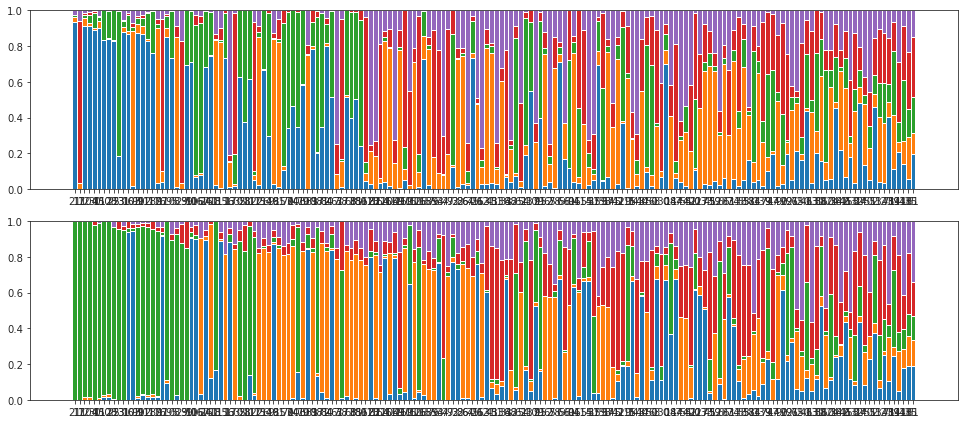

In [141]:
# nodes = np.array([sort_both[i] for i in range(100)])
nodes = sort_both
# men_means = [20, 35, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]
# men_std = [2, 3, 4, 1, 2]
# women_std = [3, 5, 2, 3, 3]
width = 1      # the width of the bars: can also be len(x) sequence

fig, axes = create_figure(2, 1, (13.5, 6))

bottom_ca = np.zeros(len(sort_ca))
bottom_bold = np.zeros(len(sort_bold))
for k in range(5):
    height = gr_ca.grp_pi_prune[k, sort_ca]
    axes[0].bar(
        x=[str(i) for i in sort_bold],
        height=height,
        width=width,
        bottom=bottom_ca,
        label=f'OC_{k}',
    )
    bottom_ca += height
    
    height = gr_bold.grp_pi_prune[k, sort_bold]
    axes[1].bar(
        x=[str(i) for i in sort_bold],
        height=height,
        width=width,
        bottom=bottom_bold,
        label=f'OC_{k}',
    )
    bottom_bold += height

plt.show()

In [150]:
x = gr_bold.grp_pi_prune.copy()
x[x < 0.2] = 0
x /= np.nansum(x, axis=0)

y = gr_ca.grp_pi_prune.copy()
y[y < 0.2] = 0
y /= np.nansum(y, axis=0)

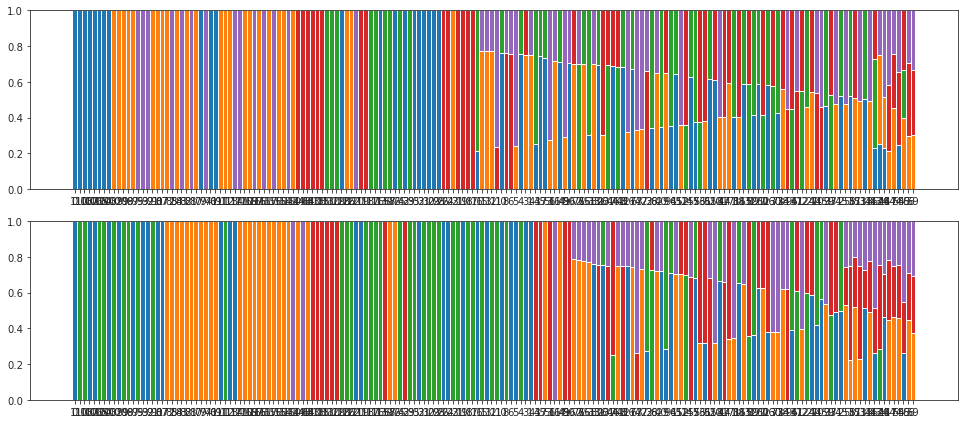

In [152]:
fig, axes = create_figure(2, 1, (13.5, 6))

sort_ca = np.argsort(sp_stats.entropy(y, axis=0))
sort_bold = np.argsort(sp_stats.entropy(x, axis=0))

bottom_ca = np.zeros(len(sort_ca))
bottom_bold = np.zeros(len(sort_bold))
for k in range(5):
    height = y[k, sort_ca]
    axes[0].bar(
        x=[str(i) for i in sort_bold],
        height=height,
        width=width,
        bottom=bottom_ca,
        label=f'OC_{k}',
    )
    bottom_ca += height
    
    height = x[k, sort_bold]
    axes[1].bar(
        x=[str(i) for i in sort_bold],
        height=height,
        width=width,
        bottom=bottom_bold,
        label=f'OC_{k}',
    )
    bottom_bold += height

plt.show()

In [153]:
sort_bold[-20:]

array([109, 159,  37,  34,   2, 153,  58,  57,  53, 133, 146, 142, 134,
        46, 147, 144,  54,  55,  66,  59])

In [154]:
sort_ca[-20:]

array([137,  14,  35, 171, 102,  84,  11,  48,  75, 105,  65, 128, 161,
       158, 143, 146, 127,  39,  41,  56])